<a href="https://colab.research.google.com/github/Chris12C/Chen123/blob/main/CNN_sound_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification for sound

**Author:** chris

**Description:** Training an image classifier for sound to classify flow patterns

## Introduction

This case is applied to recognize the acoustic signals
which contain the characteristics of different gas bubble/pocket behavior and corresponding flow patterns.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Setup


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the data



In [ ]:
!unzip  '/soundimage2.zip'
!ls

Archive:  /soundimage2.zip
   creating: Sound image/Training/
   creating: Sound image/Training/plug/
  inflating: Sound image/Training/plug/0.png  
  inflating: Sound image/Training/plug/1.png  
  inflating: Sound image/Training/plug/10.png  
  inflating: Sound image/Training/plug/11.png  
  inflating: Sound image/Training/plug/12.png  
  inflating: Sound image/Training/plug/13.png  
  inflating: Sound image/Training/plug/14.png  
  inflating: Sound image/Training/plug/15.png  
  inflating: Sound image/Training/plug/16.png  
  inflating: Sound image/Training/plug/17.png  
  inflating: Sound image/Training/plug/18.png  
  inflating: Sound image/Training/plug/19.png  
  inflating: Sound image/Training/plug/2.png  
  inflating: Sound image/Training/plug/20.png  
  inflating: Sound image/Training/plug/21.png  
  inflating: Sound image/Training/plug/22.png  
  inflating: Sound image/Training/plug/23.png  
  inflating: Sound image/Training/plug/24.png  
  inflating: Sound image/Training/plu

Now we have a `sound image` folder which contain two subfolders, `Up` and `Down`. Each
 subfolder contains image files for each category.


## Generate a `Dataset`


In [ ]:
import os
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Sound image/Training",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Sound image/Validation",
    validation_split=0.8,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 233 files belonging to 3 classes.
Using 187 files for training.
Found 72 files belonging to 3 classes.
Using 57 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 2 is "UP"
 and label 1 is "Jump" label 0 is "Down".


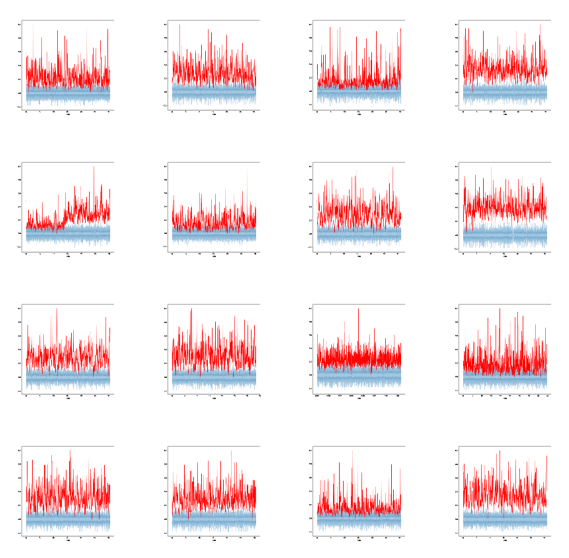

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")


## Using image data augmentation

图形增强Augmentation以免过拟合


In [ ]:
data_augmentation = keras.Sequential(
    [
        #layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.3),
    ]
)


图形增强Augmentation


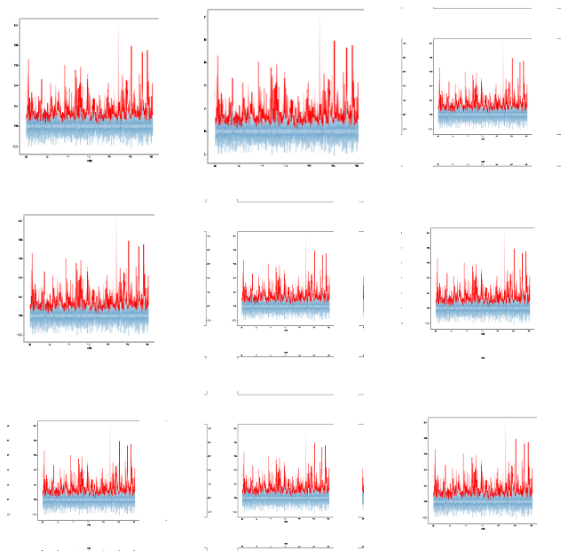

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## Build a model



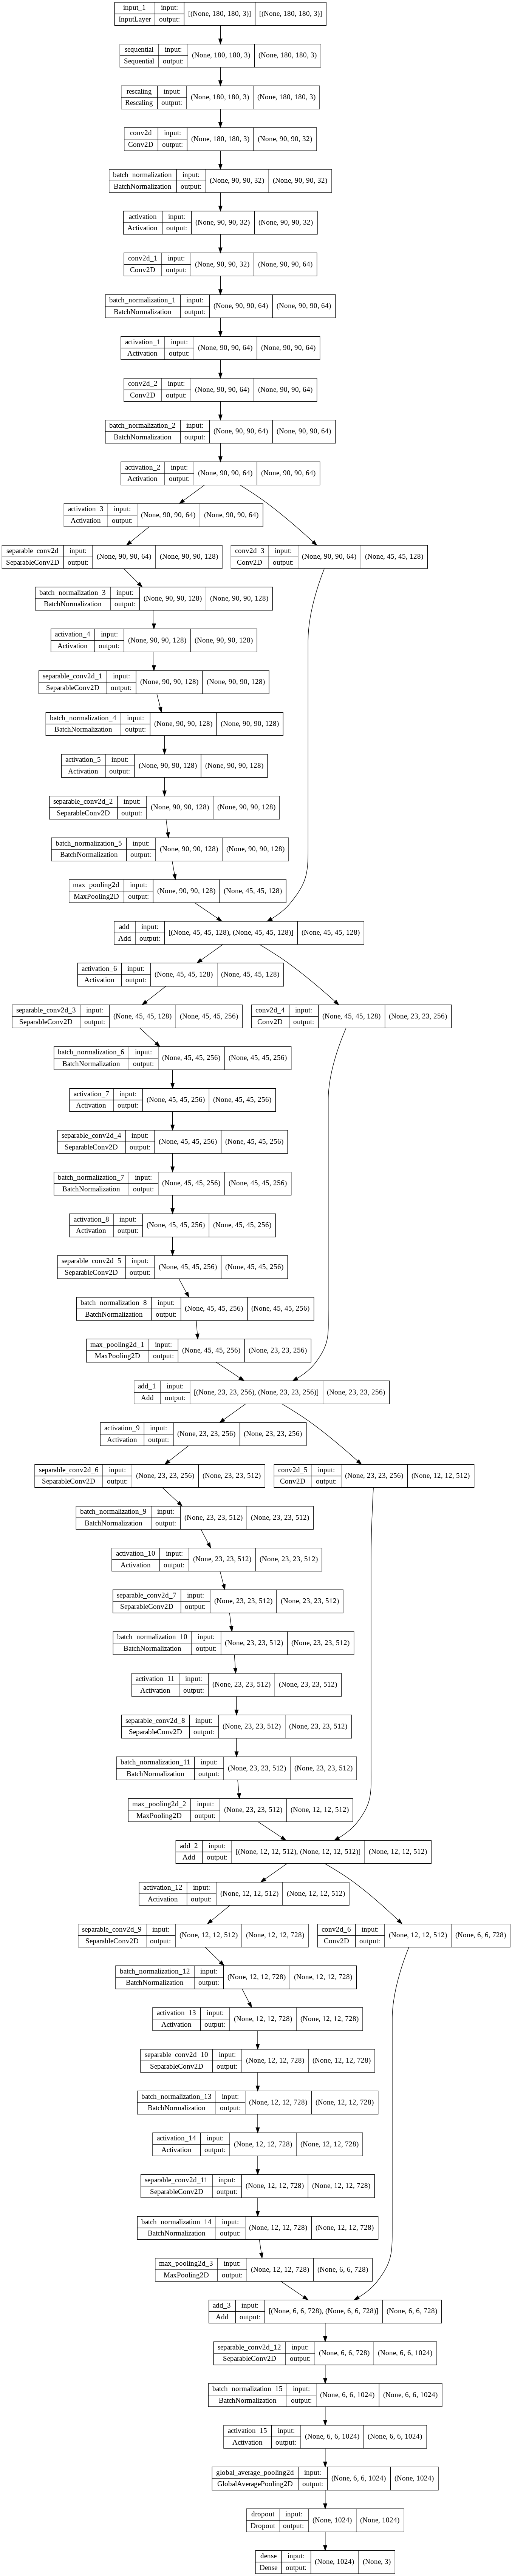

In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [ ]:
epochs = 100

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],

)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)


Epoch 1/100
6/6 [==============================] - 7s 591ms/step - loss: 0.0385 - accuracy: 0.9893 - val_loss: 11.9773 - val_accuracy: 0.1228
Epoch 2/100
6/6 [==============================] - 4s 542ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 16.9740 - val_accuracy: 0.1228
Epoch 3/100
6/6 [==============================] - 4s 513ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 14.2472 - val_accuracy: 0.1228
Epoch 4/100
6/6 [==============================] - 4s 518ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 9.1066 - val_accuracy: 0.1754
Epoch 5/100
6/6 [==============================] - 4s 510ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 5.0368 - val_accuracy: 0.3509
Epoch 6/100
6/6 [==============================] - 4s 519ms/step - loss: 0.0116 - accuracy: 0.9947 - val_loss: 1.9108 - val_accuracy: 0.7018
Epoch 7/100
6/6 [==============================] - 4s 518ms/step - loss: 0.0144 - accuracy: 0.9947 - val_loss: 0.2693 - val_accuracy: 0.9474
Epoch 8/10

We get to ~99% validation accuracy after training for 300 epochs on the full dataset.
